#Set up Colab and Drive for Project

In [30]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
%cd '/content/gdrive/My Drive/MVP Datensatz/'
train_dir = 'Trainingsdatensatz5'

/content/gdrive/My Drive/MVP Datensatz


In [0]:
from keras import optimizers
from keras import layers
from keras import models
from keras import initializers

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import backend as K


#Global Variables


In [0]:

img_width = 299
img_height = 299
opt = optimizers.Adam(learning_rate=0.001)
epochs = 20
batch_s = 30  # global batch_size


In [0]:
Abfragebild = 'Testbilder/P1040695.JPG'

Speicherort_KI_Modell = '/content/gdrive/My Drive/Keras Models'
Name_KI_Modell = '/Xception_5-1.h5'

#Create Base Model, Training and Valdidation Generators


In [0]:
# Xception

from keras.applications import Xception
base_model = Xception(
  weights = 'imagenet',
  include_top = False,
  input_shape = (299,299,3) 
 )


##Augmentations


In [0]:
featurewise_center = False
samplewise_center = False
featurewise_std_normalization = False
samplewise_std_normalization = False
zca_whitening = False
horizontal_flip = False
vertical_flip = False

brightness_range = None 
preprocessing_function = None

zca_epsilon = 1e-06
rotation_range = 3
width_shift_range = [-1, 0, +1]
height_shift_range = [-1, 0, +1]
shear_range = 0.0
zoom_range = 0.2
channel_shift_range = 0.0
cval = 0.0
interpolation_order = 1

fill_mode = 'nearest'
data_format = 'channels_last'


##Preparing Data

In [0]:
validation_split = 0.4
rescale = 1./255


In [0]:
train_datagen = ImageDataGenerator(
                          featurewise_center = featurewise_center,
                          samplewise_center = samplewise_center,
                          featurewise_std_normalization = featurewise_std_normalization,
                          samplewise_std_normalization = samplewise_std_normalization,
                          zca_whitening = zca_whitening,
                          zca_epsilon = zca_epsilon,
                          rotation_range = rotation_range,
                          width_shift_range = width_shift_range,
                          height_shift_range = height_shift_range,
                          brightness_range = brightness_range,
                          shear_range = shear_range,
                          zoom_range = zoom_range,
                          channel_shift_range = channel_shift_range,
                          fill_mode = fill_mode,
                          cval = cval,
                          horizontal_flip = horizontal_flip,
                          vertical_flip = vertical_flip,
                          preprocessing_function = preprocessing_function,
                          data_format = data_format,
                          validation_split = validation_split,
                          interpolation_order = interpolation_order,
                          rescale = rescale,
                          dtype = 'float32'
                          )

In [39]:
train_set = train_datagen.flow_from_directory(
                          train_dir, 
                          target_size = (img_width,img_height),
                          batch_size = batch_s,
                          class_mode = 'categorical',
                          subset = 'training'
                          )


Found 84 images belonging to 5 classes.


In [40]:
validation_set = train_datagen.flow_from_directory(
                          train_dir, 
                          target_size = (img_width,img_height),
                          batch_size = batch_s,
                          class_mode = 'categorical',
                          subset = 'validation'
                          )
       

Found 54 images belonging to 5 classes.


#Create and Train Model


In [0]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'relu', kernel_initializer = initializers.RandomNormal(stddev = 0.01), bias_initializer = initializers.Zeros()))
model.add(layers.Dense(5, activation = 'sigmoid', kernel_initializer = initializers.RandomNormal(stddev = 0.01), bias_initializer = initializers.Zeros()))
for layer in base_model.layers:
    layer.trainable = False


In [42]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(
                    train_set,
                    epochs = epochs,
                    validation_data = validation_set
                    )


Epoch 1/20
3/3 [==============================] - 7s 2s/step - loss: 1.5777 - acc: 0.2857 - val_loss: 1.3777 - val_acc: 0.2407
Epoch 2/20
3/3 [==============================] - 3s 858ms/step - loss: 1.1363 - acc: 0.4881 - val_loss: 1.4214 - val_acc: 0.3519
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.8931 - acc: 0.4762 - val_loss: 1.4457 - val_acc: 0.3333
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 0.6488 - acc: 0.5952 - val_loss: 1.5633 - val_acc: 0.5926
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 0.5238 - acc: 0.8452 - val_loss: 2.3325 - val_acc: 0.4815
Epoch 6/20
3/3 [==============================] - 3s 1s/step - loss: 0.6010 - acc: 0.8571 - val_loss: 4.0346 - val_acc: 0.4444
Epoch 7/20
3/3 [==============================] - 3s 1s/step - loss: 0.4289 - acc: 0.8571 - val_loss: 3.6659 - val_acc: 0.4630
Epoch 8/20
3/3 [==============================] - 3s 1s/step - loss: 0.5968 - acc: 0.7976 - val_loss: 3.9178

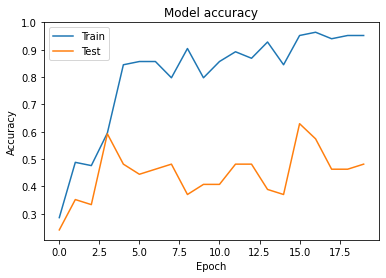

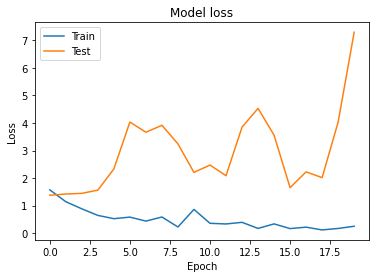

In [43]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


#Save Model

In [0]:
model.save("/content/gdrive/My Drive/Keras Models/Xception_5-1.h5")


#Load Validation Images

In [0]:
folder_path = 'Testbilder/'
model_path = '/path/to/saved/model.h5'

In [46]:
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)
classes = model.predict_classes(images)
print(classes)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#Perform Classification

In [0]:
import json
def Vorhersage(Artikelfoto, Speicherort_KI_Modell, Name_KI_Modell):

    model = models.load_model(Speicherort_KI_Modell + Name_KI_Modell)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
    Artikelfoto = image.load_img(Artikelfoto, target_size=(img_width, img_height))
    Artikelfoto = image.img_to_array(Artikelfoto)
    Artikelfoto = np.expand_dims(Artikelfoto, axis=0)
    prediction = model.predict(Artikelfoto)
    prediction = prediction.flatten()
    artikelnummer = 'Art' + str(np.argmax(prediction)+1)
    wahrscheinlichkeit = str(prediction[np.argmax(prediction)])

    response = json.dumps({"Artikelnummer":artikelnummer, "Wahrscheinlichkeit":wahrscheinlichkeit})

    return response

In [48]:
Vorhersage(Abfragebild, Speicherort_KI_Modell, Name_KI_Modell)

'{"Artikelnummer": "Art1", "Wahrscheinlichkeit": "0.0"}'